# Qiskit 2 - 2020/2021

### [Update](https://qiskit.org/documentation/release_notes.html) 

#### Qiskit 0.25.0¶

This release officially deprecates the Qiskit Aqua project. Accordingly, in a future release the qiskit-aqua package will be removed from the Qiskit metapackage, which means in that future release pip install qiskit will no longer include qiskit-aqua. The application modules that are provided by qiskit-aqua have been split into several new packages: qiskit-optimization, qiskit-nature, qiskit-machine-learning, and qiskit-finance. 

&nbsp;

## Contents

&nbsp;

1. [Working with the IBMQ backends](#ibmq)
    
    1.1 [Experimental properties](#exp)
    
    1.2 [Interactive tools](#ipywid)
    
    1.3 [Quantum half-adder, revisited](#qha)
    
    
2. [Quantum Teleportation protocol](#quantumteleport)

&nbsp;

# 1. Working with the IBMQ backends<a id='ibmq'></a>

&nbsp;

#### Loading the IBMQ account


The `IBMQ` module of Qiskit provides the framework to work with the free-access quantum devices that are currently available.

<div class="alert alert-block alert-info">
    
**Managing your [access](https://quantum-computing.ibm.com/docs/manage/account/ibmq) token**

&nbsp;


Before working with the backends for the first time, a `TOKEN` from an [IBM Quantum Experience](https://quantum-computing.ibm.com/) account is necessary. After creating and logging into an account, the token string can be copied from:

&nbsp;

<p style="text-align: center;"><a href="https://quantum-computing.ibm.com/account">https://quantum-computing.ibm.com/account</a></p>

&nbsp;

This string is used as a personal credential for handling communication with the quantum processors. There are several commands to manage credentials:

- `enable_account('TOKEN')`: Enable account in the current session.
- `save_account('TOKEN')`: Save account to disk for future use.
- `load_account()`: Load account using stored credentials.
- `disable_account()`: Disable account in the current session.
- `stored_account()`: List the account stored to disk.
- `active_account()`: List the account currently in the session.
- `delete_account()`: Delete the saved account from disk.

</div>


#### Module imports

In [1]:
from qiskit import (QuantumCircuit, ClassicalRegister, QuantumRegister, 
                    IBMQ, Aer, execute, transpile)

from qiskit.tools.visualization import plot_histogram, plot_circuit_layout, plot_gate_map

from qiskit.providers.ibmq import least_busy

from math import pi
import numpy as np

In [2]:
# Replace TOKEN with your string

#IBMQ.save_account('TOKEN')

# In subsequent sessios the Token can be loaded from disk

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

&nbsp;

By invoking `get_provider()` one can initiate a provider object to retrieve backend information or selecting a backend:

- `backends()`: Returns all backend objects known to the provider.
- `get_backend('NAME')`: Returns the named backend.

&nbsp;

In [3]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [4]:
# Use least_busy() to find out which quantum device is the least busy

physical_devices = provider.backends(simulator=False, operational=True, open_pulse=False)

backend = least_busy(physical_devices)

# Alternative: get backend directly by name

#backend = provider.get_backend('ibmq_16_melbourne')

print(backend)

ibmq_belem


## 1.1 Quantum devices - experimental properties<a id='exp'></a>

#### [Basis Gates](https://qiskit.org/documentation/apidoc/transpiler.html)

Although IBM's interface allows the user to program a quantum algorithm using a broad set of single and multi-qubit gates, these are compiled into a smaller set of compiler instruction:

In [5]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

#### [Qubit map](https://qiskit.org/documentation/apidoc/transpiler.html)

Besides the restriction regarding the available gates, there are further physical constraints given by the physical architecture of the chip. In fact, CNOT gates can be directly applied only to qubits that are connected.

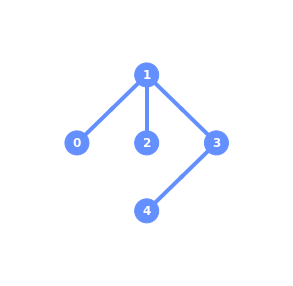

In [6]:
plot_gate_map(backend)

There are ways to circumvent the chip's architecture limitations (for example, by using SWAP operations to allow for a CNOT gate between otherwise physically uncoupled qubits). 

The study and development of efficient mapping algorithms between logical (software) and physical qubits, for a given quantum program, has only recently started receiving serious attention from the quantum information community. **As the size and complexity of quantum processor chips increase, efficient mapping algorithms will become crucial to successful demonstrations of the applications of quantum computers.**

<img src="https://qiskit.org/documentation/_images/mapping.png" width="800px" align="center">


#### Coherence times

Current quantum computations are “fragile”. A physical qubit does not hold its state indefinitely, but undergoes random bit-flips and loses its phase over time, i.e. undergoes decoherence. Decoherence is the loss of quantum "properties" of a quantum system. Quantum devices have associated decoherence times, which limit the number of quantum operations that can be performed before the results are "drowned" by noise. 

One can distinguish between two measures of decoherence:

1. $T_1$ is the "longitudinal coherence time" (also known as "amplitude damping"), and it measures loss of energy from the system.
2. $T_2$ is the "transverse coherence time" (also known as "phase damping").


<img src="https://qiskit.org/documentation/_images/tutorials_noise_2_relaxation_and_decoherence_8_1.png" width="600">
<img src="https://qiskit.org/documentation/_images/tutorials_noise_2_relaxation_and_decoherence_13_0.png" width="600">

<div class="alert alert-block alert-info">
    
**How are coherence times determined experimentally?**

&nbsp;

One way to estimate $T_1$ is to initialize a qubit to the ground state $| 0 \rangle$ (for example, apply an $X$ gate to turn it into $| 1 \rangle$, and measure it in the computational basis after a time $t$. 

The probability of the qubit staying in the $| 1 \rangle$ state is expected to follow an exponential decay curve $e^{-t/T_1}$. 

To experimentally determine $T_2$, one can initialise a qubit to the ground state $| 0 \rangle$, apply an Hadamard transform $H$ to change it into $\frac{| 0 \rangle + | 1 \rangle}{\sqrt{2}}$ and wait for a time $t$ before applying another transform $H$ and measuring the qubit on the computational basis.

You can try [Relaxation and Decoherence](https://qiskit.org/documentation/tutorials/noise/2_relaxation_and_decoherence.html).
    
**Note** T1 and T2 are not "time from state x to state y" but rather decay constants.
                                                                                      
</div>

&nbsp;

Information on a given `backend`, such as qubit configuration or noise properties, can be retrieved by calling on the instance 
properties.

In [7]:
# Check backend status
backend.status()

In [8]:
# Check configuration
config = backend.configuration()

# to_dict() displays configuration in dict form - easier to read
config.to_dict()

{'backend_name': 'ibmq_belem',
 'backend_version': '1.0.6',
 'n_qubits': 5,
 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'],
 'gates': [{'name': 'id',
   'parameters': [],
   'qasm_def': 'gate id q { U(0, 0, 0) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'rz',
   'parameters': ['theta'],
   'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'sx',
   'parameters': [],
   'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'x',
   'parameters': [],
   'qasm_def': 'gate x q { U(pi, 0, pi) q; }',
   'coupling_map': [[0], [1], [2], [3], [4]]},
  {'name': 'cx',
   'parameters': [],
   'qasm_def': 'gate cx q0, q1 { CX q0, q1; }',
   'coupling_map': [[0, 1],
    [1, 0],
    [1, 2],
    [1, 3],
    [2, 1],
    [3, 1],
    [3, 4],
    [4, 3]]},
  {'name': 'reset', 'parameters': None, 'qasm_def': None}],
 'local': False,
 'simulator': False,
 'condit

In [9]:
properties = backend.properties()

properties.to_dict()

{'backend_name': 'ibmq_belem',
 'backend_version': '1.0.6',
 'last_update_date': datetime.datetime(2021, 4, 8, 5, 44, 32, tzinfo=tzlocal()),
 'qubits': [[{'date': datetime.datetime(2021, 4, 8, 5, 11, 32, tzinfo=tzlocal()),
    'name': 'T1',
    'unit': 'us',
    'value': 85.09239307376956},
   {'date': datetime.datetime(2021, 4, 8, 5, 13, 40, tzinfo=tzlocal()),
    'name': 'T2',
    'unit': 'us',
    'value': 133.5253127924614},
   {'date': datetime.datetime(2021, 4, 8, 5, 44, 32, tzinfo=tzlocal()),
    'name': 'frequency',
    'unit': 'GHz',
    'value': 5.090208848215397},
   {'date': datetime.datetime(2021, 4, 8, 5, 44, 32, tzinfo=tzlocal()),
    'name': 'anharmonicity',
    'unit': 'GHz',
    'value': -0.33612300518216515},
   {'date': datetime.datetime(2021, 4, 8, 5, 11, 11, tzinfo=tzlocal()),
    'name': 'readout_error',
    'unit': '',
    'value': 0.036599999999999966},
   {'date': datetime.datetime(2021, 4, 8, 5, 11, 11, tzinfo=tzlocal()),
    'name': 'prob_meas0_prep1',
    '

&nbsp;


## 1.2 Interactive tools <a id='ipywid'></a>

The large amount of information on different backends can better be visualized using the integrated interactive tools.

In [10]:
# NOTE: if interactive tools don't work,
# you may need to install ipywidgets.
# If so, execute the line below:

# !pip install ipywidgets

# Interactive tools
import qiskit.tools.jupyter
%matplotlib inline

In [11]:
%qiskit_version_table

In [12]:
%qiskit_backend_overview

After importing the tools, simply invoking a backend instance displays graphical information on the backend.

In [13]:
backend

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

&nbsp;


## 1.3 Quantum half-adder, revisited <a id='qha'></a>

&nbsp;


Recall the quantum half-adder circuit from the previous class, which adds the states of $q_0$ and $q_1$, and outputs the *sum* S to $q_1$ and the *carry* C to an additional qubit $q_2$:

&nbsp;

| $q_0$ (input) = A | $q_1$ (input) = B | $q_1$ (output) = S  | $q_2$ (output) = C |
|-----------------|-----------------|-------------------|------------------|
|        0        |         0       |      0            |      0     |
|        1        |         0       |      1            |      0     |
|        0        |         1       |      1            |      0     |
|        1        |         1       |      0            |      1     |


&nbsp;


We can now compare the results of the quantum half adder under ideal conditions (when using the simulator), vs. when executed on a physical quantum processor.

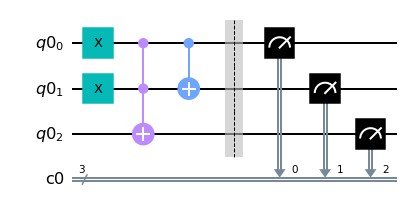

In [14]:
# Create registers
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

# Quantum Circuit
half_adder = QuantumCircuit(qr, cr)

# We are adding q0 = |1> and q1 = |1>
half_adder.x(qr[0])
half_adder.x(qr[1])

# Perform operation
half_adder.ccx(qr[0], qr[1], qr[2])
half_adder.cx(qr[0], qr[1])

# Barriers make circuits prettier
half_adder.barrier()

# Measure
half_adder.measure(qr, cr)

# Draw
half_adder.draw(output='mpl')

Recall that under noiseless settings and deterministic inputs (since inputs are not in superposition), the output is deterministic: $q_0 = 1$, $q_1 = 0$ (sum) and $q_2 = 1$ (carry). We therefore expect the measured outcome to be `101`.

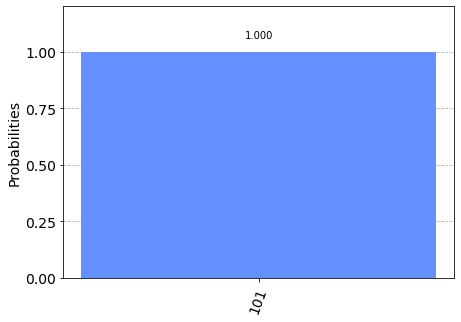

In [15]:
sim_backend = Aer.get_backend("qasm_simulator")

shots = 1024
job_half_adder_s = execute(half_adder, sim_backend, shots=shots)

result_half_adder_s = job_half_adder_s.result()
counts_half_adder_sim = result_half_adder_s.get_counts(half_adder)

plot_histogram(counts_half_adder_sim)

#### Visualizing circuit decompositions

Before being executed on a physical backend, the circuit is decomposed. This decomposition can be visualized using the `transpile` function.

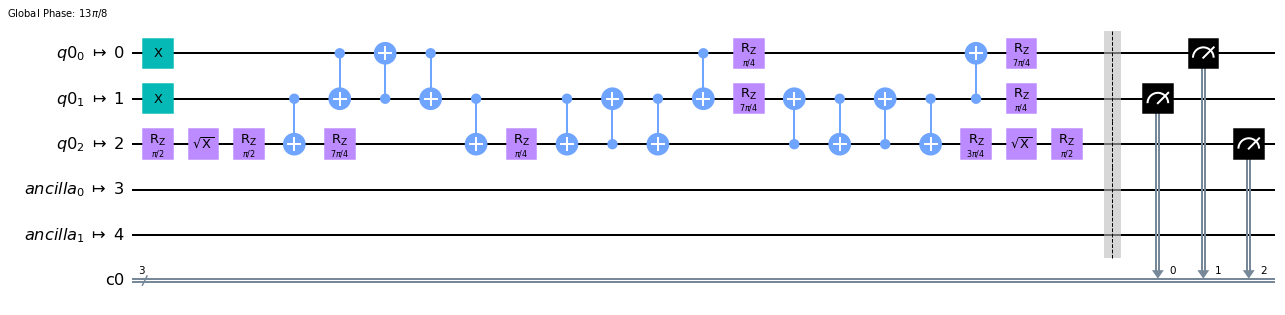

In [16]:
# To visualize the decomposition, we have to specify the backend
# get_backend() to define backend
physical_backend = provider.get_backend('ibmq_belem')

                       
# With transpile we can see exactly what is running on the backend
qc_real = transpile(half_adder, backend=physical_backend)

qc_real.draw(output='mpl')

#### Comparing the number of layers

We can compare the number of *layers* between the original and the compiled circuit. 

A *layer* is comprised of all quantum operations that can be executed concurrently, before the quantum device executes the next cycle of operations.

<img src="https://qiskit.org/documentation/locale/de_DE/_images/depth.gif" width="800 px" />

In [17]:
print('Original circuit')
print('Depth:', half_adder.depth())
print('Gate counts:', half_adder.count_ops())
print()

circlist=[]
for kk in range(4):
    circ = transpile(half_adder, backend, optimization_level=kk)
    circlist.append(circ)
    print('Optimization Level {}'.format(kk))
    print('Depth:', circ.depth())
    print('Gate counts:', circ.count_ops())
    print()

Original circuit
Depth: 4
Gate counts: OrderedDict([('measure', 3), ('x', 2), ('ccx', 1), ('cx', 1), ('barrier', 1)])

Optimization Level 0
Depth: 53
Gate counts: OrderedDict([('rz', 33), ('sx', 24), ('cx', 13), ('measure', 3), ('x', 2), ('barrier', 1)])

Optimization Level 1
Depth: 24
Gate counts: OrderedDict([('cx', 17), ('rz', 10), ('measure', 3), ('x', 2), ('sx', 2), ('barrier', 1)])

Optimization Level 2
Depth: 22
Gate counts: OrderedDict([('cx', 14), ('rz', 10), ('measure', 3), ('x', 2), ('sx', 2), ('barrier', 1)])

Optimization Level 3
Depth: 26
Gate counts: OrderedDict([('rz', 19), ('sx', 11), ('cx', 9), ('measure', 3), ('x', 1), ('barrier', 1)])



We can also visually see which qubits are used for the circuit.

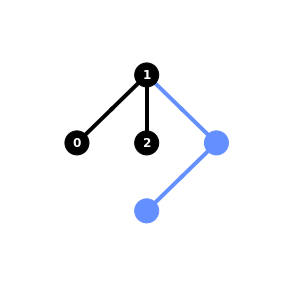

In [18]:
plot_circuit_layout(circlist[0], physical_backend)

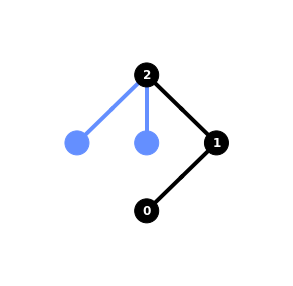

In [19]:
plot_circuit_layout(circlist[3], physical_backend)

#### Comparing results

In [ ]:
# Execute the DJ algorithm on physical backend

# Enable job monitoring
%qiskit_job_watcher

# To disable: %qiskit_disable_job_watcher

job_ha_real = execute(circlist[1], physical_backend, shots=shots)

In [ ]:
# We can save the job ID to retrieve results even after closing the notebook
#job_ha_real.job_id()

# This can be achieved using the retrieve_job('ID') method
#job_ha_real = physical_backend.retrieve_job('ID')

In [ ]:
# We can also check the job status
job_ha_real.status()

In [ ]:
result_ha_real = job_ha_real.result()
counts_ha_real = result_ha_real.get_counts(half_adder)

plot_histogram([counts_ha_real, counts_half_adder_sim], legend=[ 'real device', 'ideal'])

&nbsp;

# 2. Quantum Teleportation protocol<a id='quantumteleport'></a>

&nbsp;

Quantum teleportation is a protocol to transmit quantum states from one location to another, assisted by a previously shared entangled state and a classical communication channel. It was devised by Charles H. Bennett (IBM), Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and William K. Wootters in [1993](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.70.1895). It was first demonstrated with photons in [1997](http://www.nature.com/nature/journal/v390/n6660/abs/390575a0.html), and has since been realised in [atoms](http://www.nature.com/nphys/journal/v9/n7/abs/nphys2631.html), [ions](http://www.nature.com/nature/journal/v429/n6993/full/nature02570.html), [electrons](http://science.sciencemag.org/content/345/6196/532) and [superconducting circuits](http://www.nature.com/nature/journal/v500/n7462/full/nature12422.html). The [record](https://www.nature.com/articles/nature23675) distance for quantum teleportation is 1400 km via satellite.


<img src="https://qiskit.org/textbook/ch-algorithms/images/tele1.jpg" width="600 px" align="center">

As illustrated above, the protocol starts out with a shared entangled state between the sender (Alice) and the receiver (Bob):
$$|\psi\rangle_{AB} = \frac{1}{\sqrt{2}}(|0\rangle_A \otimes |0\rangle_B + |1\rangle_A \otimes |1\rangle_B)$$
The first qubit, denoted by subscript $A$, belongs to Alice, and the second qubit, $B$, belongs to Bob.

Alice has a quantum state that she wants to convey to Bob:
$$|\psi\rangle_{C} = \alpha|0\rangle_C + \beta|1\rangle_C$$

At this point, Alice has two quantum states ($C$, the one she wants to teleport, and $A$, one of the entangled pair), and Bob has one quantum state. The total state of the system is given by:
$$|\psi\rangle_{AB} \otimes |\psi\rangle_C = \frac{1}{\sqrt{2}}(|0\rangle_A  |0\rangle_B + |1\rangle_A |1\rangle_B) \otimes (\alpha|0_C\rangle + \beta|1_C\rangle)$$


Alice now measures her two quantum states, $A$ and $C$, in the [Bell basis](https://www.quantiki.org/wiki/bell-basis). This will collapse the three state system into the one of the following four states with equal probability, with the corresponding measurement outcomes:
- **00**: $|\Phi^+\rangle_{AC}\otimes(\alpha|0\rangle_B + \beta|1\rangle_B)$
- **01**: $|\Phi^-\rangle_{AC}\otimes(\alpha|0\rangle_B - \beta|1\rangle_B)$
- **10**: $|\Psi^+\rangle_{AC}\otimes(\alpha|1\rangle_B + \beta|0\rangle_B)$ 
- **11**: $|\Psi^-\rangle_{AC}\otimes(-\alpha|1\rangle_B + \beta|0\rangle_B)$

Alice now sends the results of her measurements to Bob. Using this information, he performs one of the following transformations on his quantum state to transform it to the desired state $\alpha|0\rangle_B + \beta|1\rangle_B$:

- If he receives **00**, he applies $I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$
- If he receives **01**, he applies $Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}$
- If he receives **10**, he applies $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ 
- If he receives **11**, he applies $XZ = \begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix}$ 

Transmission (teleportation) of $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ is thus achieved. 

<div class="alert alert-block alert-warning">

**Exercise 2 - Implementing the quantum teleportation protocol**

&nbsp;

Implement the quantum teleportation protocol in the cell below. For this example, we can admit that the quantum state to teleport is $|qc \rangle = \frac{1}{2} |0\rangle + \frac{\sqrt{3}}{2} |1\rangle$.

&nbsp;


The protocol can be broken down into several steps:

- Entangle qubits `qa` and `qb` so that $|qa \; qb \rangle = |00\rangle + |11\rangle$. This can be achieved with a Hadamard and a CNOT gate;


- Prepare the state $|qc\rangle$ as stated above; this can be achieved by a rotation around the y-axis of the qubit, which can be performed by the Ry gate: `ry(pi/3, qc)`;


- To measure Alice's qubits in the [Bell basis](https://www.quantiki.org/wiki/bell-basis), she first has to apply the inverse of the entanglement operation on her two qubits - a `CNOT` followed by a Hadamard (this is already filled below);


- Measure `qa` into bit $b_0$ and `qb` into bit $b_1$; as per the order above, $b_0 b_1 = A \, C$;


- Apply gate `Z` to `qb` if $b_0 = 1$, and apply `X` to `qb` if $b_1 = 1$;


- To verify that the protocol worked correctly, reverse `qb` into $|0\rangle$ by applying the inverse of the initial operation on `qc`: `ry(-pi/3, qc)`


If the protocol was correctly applied, Bob should measure `0` independetly of Alice's results.
</div>


<div class="alert alert-block alert-info">
    
**Quantum operations with classical controls**

Qiskit allows for any quantum operation to be performed conditionally. For that, you need to append `c_if(bit, value)` to the original gate. 

E.g. to apply the Z gate to qubit `qb` if bit `b[0]` == 1: `qc.z(qb).c_if(b[0], 1)`

</div>

Refs: 
* [Qiskit textbook teleportation](https://qiskit.org/textbook/ch-algorithms/teleportation.html)
* [quantum teleportation](https://www.youtube.com/watch?v=DxQK1WDYI_k&list=PL0E2ABD1D84697428&index=15)

In [ ]:
# Qubits A, B and C as separate registers
qc = QuantumRegister(1, 'qc')
qa = QuantumRegister(1, 'qa')
qb = QuantumRegister(1, 'qb')

# Alice needs two bits; Bob needs one
c_alice0 = ClassicalRegister(1)
c_alice1 = ClassicalRegister(1)
c_bob = ClassicalRegister(1)

# Initialize circuit
teleport = QuantumCircuit(qc, qa, qb, c_alice0, c_alice1, c_bob)

# Entangle qa and qb


# Prepare state |qc> on qubit qc
teleport.barrier()

# Project qc and qa into the Bell basis
teleport.cx(qc, qa)
teleport.h(qc)

# Measure qc and qa into c_alice[0] and c_alice[1]

teleport.barrier()

# Perform conditional operations on qb
# <circuit>.<gate>(<qubit>).c_if(<bit>, 1)

# Revert qb to |0>

# Measure qb to c_bob

# Draw circuit
teleport.draw(output='mpl')